## Time processing for ONNX nodes

The following notebook show how long the runtime spends in each node of an ONNX graph.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%load_ext mlprodict

## LogisticRegression

In [3]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
iris = load_iris()
X, y = iris.data, iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y)
clr = LogisticRegression(solver='liblinear')
clr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [4]:
import numpy
from skl2onnx import to_onnx
onx = to_onnx(clr, X_test.astype(numpy.float32))
%onnxview onx

The maximum opset needed by this model is only 9.
The maximum opset needed by this model is only 1.


In [5]:
from mlprodict.onnxrt import OnnxInference
import pandas
oinf = OnnxInference(onx)
res = oinf.run({'X': X_test}, node_time=True)
pandas.DataFrame(list(res[1]))

,i,name,op_type,time
0,0,LinearClassifier,LinearClassifier,0.003785
1,1,Normalizer,Normalizer,0.000071
2,2,Cast,Cast,0.000014
3,3,ZipMap,ZipMap,0.000069


In [6]:
oinf.run({'X': X_test})['output_probability'][:5]

array([{}, {}, {}, {}, {}], dtype=object)

## More measures

In [7]:
from mlprodict.onnxrt.validate import enumerate_validated_operator_opsets
res = list(enumerate_validated_operator_opsets(
            verbose=0, models={"LogisticRegression"}, opset_min=11,
            runtime='python', debug=False, node_time=True))

The maximum opset needed by this model is only 9.
The maximum opset needed by this model is only 1.
The maximum opset needed by this model is only 9.
The maximum opset needed by this model is only 1.
The maximum opset needed by this model is only 9.
The maximum opset needed by this model is only 1.
The maximum opset needed by this model is only 9.
The maximum opset needed by this model is only 1.


In [8]:
import pandas
df = pandas.DataFrame(res[0]['bench-batch'])
df['step'] = df.apply(lambda row: '{}-{}'.format(row['i'], row["name"]), axis=1)
df

,N,i,max_time,min_time,name,number,op_type,repeat,time,step
0,1,0,0.000040,0.000013,LinearClassifier,20,LinearClassifier,20,0.000025,0-LinearClassifier
1,1,1,0.000032,0.000012,Normalizer,20,Normalizer,20,0.000025,1-Normalizer
2,1,2,0.000010,0.000004,Cast,20,Cast,20,0.000007,2-Cast
3,1,3,0.000023,0.000009,ZipMap,20,ZipMap,20,0.000016,3-ZipMap
4,10,0,0.000060,0.000016,LinearClassifier,20,LinearClassifier,20,0.000027,0-LinearClassifier
5,10,1,0.000059,0.000014,Normalizer,20,Normalizer,20,0.000023,1-Normalizer
6,10,2,0.000021,0.000004,Cast,20,Cast,20,0.000006,2-Cast
7,10,3,0.000043,0.000014,ZipMap,20,ZipMap,20,0.000021,3-ZipMap
8,100,0,0.000053,0.000031,LinearClassifier,5,LinearClassifier,5,0.000040,0-LinearClassifier
9,100,1,0.000052,0.000023,Normalizer,5,Normalizer,5,0.000034,1-Normalizer


In [9]:
piv = df.pivot('step', 'N', 'time')
total = piv.sum(axis=0)
piv / total

N,1,10,100,1000,10000,100000
step,,,,,,
0-LinearClassifier,0.342966,0.349061,0.217533,0.110029,0.042743,0.054202
1-Normalizer,0.343206,0.298389,0.183136,0.072729,0.027956,0.034972
2-Cast,0.093832,0.082493,0.041946,0.008727,0.001193,0.000734
3-ZipMap,0.219997,0.270057,0.557385,0.808515,0.928108,0.910092


The implementation of *ZipMap* is not efficient for big datasets. It nearly takes 95% of the total time.

In [10]:
from pyquickhelper.pycode.profiling import profile
bigX = numpy.random.randn(100000, X_test.shape[1]).astype(numpy.float32)
df = profile(lambda: oinf.run({'X': bigX}), as_df=True)[1]
df

,namefct,file,ncalls1,ncalls2,tin,cum_tin,tall,cum_tall
0,onnx_inference.py:568-run,C:\xavierdupre\__home_\GitHub\mlprodict\mlprod...,2,2,4.211353e-04,8.090855e-04,5.407148e-01,8.112662e-01
1,627-_run_sequence_runtime,C:\xavierdupre\__home_\GitHub\mlprodict\mlprod...,7,7,9.599989e-05,1.291850e-04,5.402937e-01,8.104571e-01
2,onnx_inference_node.py:95-run,C:\xavierdupre\__home_\GitHub\mlprodict\mlprod...,24,24,9.086409e-05,1.509134e-04,5.401949e-01,8.103224e-01
3,_op.py:74-run,C:\xavierdupre\__home_\GitHub\mlprodict\mlprod...,8,8,4.333269e-02,4.335244e-02,5.400930e-01,8.101494e-01
4,op_zipmap.py:95-_run,C:\xavierdupre\__home_\GitHub\mlprodict\mlprod...,100003,100003,2.078346e-01,2.423764e-01,4.481069e-01,6.894313e-01
5,<ipython-input-10-f7897c639ae2>:3-<lambda>,<ipython-input-10-f7897c639ae2>:3,2,2,3.938761e-04,3.938761e-04,5.411087e-01,5.411087e-01
6,op_zipmap.py:96-<lambda>,C:\xavierdupre\__home_\GitHub\mlprodict\mlprod...,200000,200000,2.066526e-01,3.798155e-01,2.401423e-01,4.467949e-01
7,op_zipmap.py:24-__init__,C:\xavierdupre\__home_\GitHub\mlprodict\mlprod...,100000,100000,3.348974e-02,6.697948e-02,3.348974e-02,6.697948e-02
8,op_linear_classifier.py:37-_run,C:\xavierdupre\__home_\GitHub\mlprodict\mlprod...,3,3,1.593559e-02,2.470160e-02,2.951463e-02,4.865495e-02
9,op_normalizer.py:46-_run,C:\xavierdupre\__home_\GitHub\mlprodict\mlprod...,2,2,6.226561e-03,6.230116e-03,1.885193e-02,2.827967e-02


In [11]:
%matplotlib inline

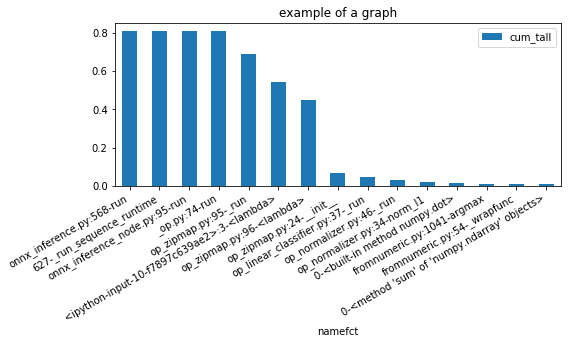

In [12]:
ax = df[['namefct', 'cum_tall']].head(n=15).set_index('namefct').plot(kind='bar', figsize=(8, 3), rot=30)
ax.set_title("example of a graph")
for la in ax.get_xticklabels():
    la.set_horizontalalignment('right');